# Recipe Cropper

#### Fine-Tuning SegFormer for Image Segmentation

A project to fine-tune a semantic segmentation model (SegFormer) for automatically removing backgrounds from recipe images. The model is trained on a custom dataset of recipe photos provided by the Post-Production Team at the Creative Studio.

This notebook includes:
1. Training using standard train / validation / test splits
2. Inference
2. Model deployment with Databricks

Note: This notebook is optimized for CPU training. For the GPU-optimized version, check `RecipeCropper_v2_SegFormer_GPU.ipynb`.

### Requirements

In [0]:
!pip install -q --upgrade pip

In [0]:
!pip install -U -q mlflow mlflow[extras] transformers torch torchvision evaluate accelerate ipywidgets datasets boto3

In [0]:
dbutils.library.restartPython()

In [0]:
# Check library versions
import sys
import mlflow
import transformers
import torch
import torchvision
import evaluate
import accelerate
import ipywidgets
import pyspark
import datasets

print("python version:", sys.version)
print("mlflow version:", mlflow.__version__)
print("transformers version:", transformers.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("evaluate version:", evaluate.__version__)
print("accelerate version:", accelerate.__version__)
print("ipywidgets version:", ipywidgets.__version__)
print("pyspark version:", pyspark.__version__)
print("datasets version:", datasets.__version__)

### Import Libraries

In [0]:
import base64
import json
import logging
import os
import random
import sys
from io import BytesIO
from pathlib import Path
from typing import Callable, Tuple

import boto3

import matplotlib.pyplot as plt

import mlflow
import mlflow.pyfunc

import numpy as np

import psutil
import requests

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image, ImageDraw

from sklearn.metrics import f1_score, jaccard_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.utils.data.distributed import DistributedSampler

from tqdm import tqdm

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation


#### Environment variables

For distributed training and model deployment.

In [0]:
# Databricks credentials
os.environ["DATABRICKS_HOST"] = "https://company.cloud.databricks.com"
os.environ["DATABRICKS_TOKEN"] = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiToken().get()

### Load Dataset

Two custom PyTorch datasets for semantic segmentation:

1. `CustomSegmentationDataset`
  - Handles image/annotation pairs with optional augmentation
  - Uses SegFormer feature extractor for preprocessing
  - Supports percentage-based subset sampling

2. `OversampledSegmentationDataset`:
  - Wraps `CustomSegmentationDataset`to create larger datasets
  - Generates additional samples through augmentation, while keeping original samples


Built for use with SegFormer models ([docs](https://huggingface.co/docs/transformers/en/model_doc/segformer)).

In [0]:
# Set dataset name
dataset_name = "dataset_20dec"

In [0]:
class CustomSegmentationDataset(Dataset):
  """
  Custom dataset for semantic image segmetation tasks.

  Loads and preprocesses image/annotation pairs for training segmentation models.
  Supports data augmentation and subset sampling. Images and annotations are processed
  using a feature extractor and label mapping function.

  Args:
    - image_dir: Directory path contaning image files.
      Supported formats: .png, .jpg, .jpeg
    - annotation_dir: Directory path contaning annotation files.
      Must contain .png files matching the image filenames,
    - feature_extractor: Feature extractor to convert the images/annotations into model-ready tensors.
    - image_files (optional): Specific list of image filenames to use.
      If None, all valid images in image_dir will be used.
    - annotation_files (optional): Specific list of annotation filenames to use.
      If None, all valid annotations in annotation_dir will be used.
    - augmentation (optional): Whether to apply data augmentations. Default: True.
    - percentage (optional): Fraction of the dataset to use (0 to 1).
      Useful for creating smaller training subsets for testing.
      Default: 1.0 (use full dataset).

  Raises:
    ValueError: If percentage is not between 0 and 1.
    ValueError: If the number of image files doesn't match the number of annotation files.
  """
  VALID_IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg"}
  VALID_ANNOTATION_EXTENSIONS = {".png", ".jpg"}

  def __init__(self, 
               image_dir: str, 
               annotation_dir: str, 
               feature_extractor: SegformerFeatureExtractor,
               image_files: list[str] = None, 
               annotation_files: list[str] = None,
               augmentation: bool = True,
               percentage: float = 1.0):
    if not 0 < percentage <= 1.0:
      raise ValueError("Percentage must be between 0 and 1")

    self.image_dir = Path(image_dir)
    self.annotation_dir = Path(annotation_dir)
    self.feature_extractor = feature_extractor
    self.augmentation = augmentation

    # Get list of image/annotation files from directories if not provided by image_files/annotation_files
    self.image_files = (self._get_image_files() if image_files is None else image_files)
    self.annotation_files = (self._get_annotation_files() if annotation_files is None else annotation_files)

    if len(self.image_files) != len(self.annotation_files):
      raise ValueError(f"Number of images ({len(self.image_files)}) and number of annotations ({len(self.annotation_files)}) must match.")

    # Sample subset of dataset if needed
    if percentage < 1.0:
      self._sample_subset(percentage)

  def _get_image_files(self) -> list[str]:
    """Gets list of valid image files from directory."""
    return sorted(f.name for f in self.image_dir.iterdir() if f.suffix.lower() in self.VALID_IMAGE_EXTENSIONS)
  
  def _get_annotation_files(self) -> list[str]:
    """Gets list of valid annotation files from directory."""
    return sorted(f.name for f in self.annotation_dir.iterdir() if f.suffix.lower() in self.VALID_ANNOTATION_EXTENSIONS)

  def _sample_subset(self, percentage: float) -> None:
    """Randomly sample a subset of the dataset."""
    subset_size = int(len(self.image_files) * percentage)
    indices = random.sample(range(len(self.image_files)), subset_size)
    self.image_files = [self.image_files[i] for i in indices]
    self.annotation_files = [self.annotation_files[i] for i in indices]

  def __len__(self) -> int:
    """Returns the total number of image/annotation pairs."""
    return len(self.image_files)
  
  def __getitem__(self, idx: int) -> (torch.Tensor, torch.Tensor):
    """
    Retrieves the image and its corresponding annotation at the given index.

    Args:
      - idx: Index of the image/annotation pair to retrieve.

    Returns:
      A tuple containing:
        - pixel_values: Processed image tensor ready for the model.
        - labels: Processed annotation tensor with mapped labels.
    """
    # Get file paths
    image_path = self.image_dir / self.image_files[idx]
    annotation_path = self.annotation_dir / self.annotation_files[idx]

    # Load and convert images to RGB and annotations to grayscale
    image = Image.open(image_path).convert("RGB")
    annotation = Image.open(annotation_path).convert("L")

    # Apply augmentations if enabled
    if self.augmentation:
      seed = torch.randint(0, 2**32, (1,)).item()
      image, annotation = augment(image, annotation, seed)

    # Convert annotation to binary mask
    binary_mask = convert_mask_to_binary(annotation)

    # Process image/labels using feature extractor
    encoded_inputs = self.feature_extractor(image, binary_mask, return_tensors="pt")

    # Get pixel values/labels from encoded inputs
    pixel_values = encoded_inputs["pixel_values"].squeeze(0)
    labels = encoded_inputs["labels"].squeeze(0)

    return pixel_values, labels
  
class OversampledSegmentationDataset(Dataset):
  """
  Custom dataset for semantic segmentation with augmented oversampling.

  Takes an existing CustomSegmentationDataset and increases its size by adding augmented samples
  until reaching the target number of samples.

  Args:
    base_dataset: CustomSegmentationDataset to augment.
    target_samples: Total number of samples desired.
    seed: Random seed for reproducibility.
  """
  def __init__(self, base_dataset: CustomSegmentationDataset, target_samples: int, seed: int = 42):
    self.base_dataset = base_dataset
    self.seed = seed
    self.augmented_samples = []

    # Only oversample dataset if target samples is larger than base dataset
    if target_samples > len(base_dataset):
      print(f"Original dataset size: {len(base_dataset)}")
      print(f"Adding {target_samples - len(base_dataset)} augmented samples...")
      self._create_augmented_samples(target_samples)
    else:
      print(f"Target samples ({target_samples}) <= original dataset size ({len(base_dataset)}).")
      print("Using original dataset without oversampling.")
    
  def _create_augmented_samples(self, target_samples: int) -> None:
    """Generate augmented samples to reach target size."""
    samples_to_add = target_samples - len(self.base_dataset)

    for _ in range(samples_to_add):
      # Randomly pick an index from original dataset
      idx = random.randint(0, len(self.base_dataset) - 1)

      # Get and augment original image/annotation pair
      image_path = self.base_dataset.image_dir / self.base_dataset.image_files[idx]
      annotation_path = self.base_dataset.annotation_dir / self.base_dataset.annotation_files[idx]

      # Load and convert images to RGB and annotations to grayscale
      image = Image.open(image_path).convert("RGB")
      annotation = Image.open(annotation_path).convert("L")

      # Generate random seed and create augmented version
      aug_seed = torch.randint(0, 2**32, (1,)).item()
      aug_image, aug_annotation = augment(image, annotation, aug_seed)

      # Store augmented pair
      self.augmented_samples.append((aug_image, aug_annotation))

    def __len__(self) -> int:
      return len(self.base_dataset) + len(self.augmented_samples)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
      if idx < len(self.base_dataset):
        return self.base_dataset[idx]
      else:
        aug_image, aug_annotation = self.augmented_samples[idx - len(self.base_dataset)]

        # Convert annotation to binary mask
        binary_mask = convert_mask_to_binary(aug_annotation)

        # Process image/labels using feature extractor
        encoded_inputs = self.base_dataset.feature_extractor(aug_image, binary_mask, return_tensors="pt")

        # Get pixel values/labels from encoded inputs
        pixel_values = encoded_inputs["pixel_values"].squeeze(0)
        labels = encoded_inputs["labels"].squeeze(0)

        return pixel_values, labels

In [0]:
# Label mapping
def convert_mask_to_binary(mask: Image.Image) -> torch.Tensor:
    """
    Converts an annotation image to binary format where:
        - 0 = background (black)
        - 1 = foreground (any non-black pixel)
    
    Args:
        - mask: PIL Image in grawscale ('L') mode

    Returns:
        Binary PyTorch tensor with binary labels.
    """
    # Convert to numpy array
    mask_array = np.array(mask)

    # Convert to binary (0 for black background, 1 for everything else)
    mask_binary = (mask_array > 0).astype(np.int64)

    return torch.from_numpy(mask_binary) 

#### Data Augmentation

In [0]:
# Data Augmentation
def augment(image: Image.Image, mask: Image.Image, seed: int) -> Tuple[Image.Image, Image.Image]:
    """
    Applies data augmentation to an image and its mask.

    Performs the following augmentations in sequence:
        1. Color jitter (image only): Randomly changes brightness, contrast, saturation, and hue.
        2. Random affine transformation: Applies random rotation, translation, scaling, and shearing.
        3. Horizontal flip: Randomly flips the image and mask horizontally.
        4. Vertical flip: Randomfly flips the image and mask vertically.

    Args:
        - image: The input image to be augmented.
        - mask: The corresponding segmentation mask of the input image.
        - seed: Random seed for reproducibility.

    Returns:
        Tuple with the the augmented (image, mask) pair.
    """
    torch.manual_seed(seed)

    # ColorJitter
    color_jitter = T.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.2
    )
    image = color_jitter(image)

    # RandomAffine
    affine = T.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ) # Set affine params once and apply to both image and mask
    params = affine.get_params(affine.degrees, affine.translate, affine.scale, affine.shear, image.size)
    image = T.functional.affine(image, *params)
    mask = T.functional.affine(mask, *params)

    # Horizontal Flip
    if random.random() > 0.5:
        image = T.functional.hflip(image)
        mask = T.functional.hflip(mask)

    # Vertical Flip
    if random.random() > 0.5:
        image = T.functional.vflip(image)
        mask = T.functional.vflip(mask)

    return image, mask

#### Creating datasets

- `dataset`: Full dataset for K-Fold Cross-Validation.
- `train` / `validation` / `test` split: 72% / 18% / 10% using `train_test_split`

`SegformerFeatureExtractor` configuration:
- `reduce_labels=False`: Preserves background class (0). `reduce_labels=True` will replace 0 by 255, which is the `ignore_index` of the loss function used by Segformer.
- `do_rescale=False`: Maintains original pixel values.

In [0]:
# Paths to dataset
root_dir = Path("<PATH>/recipe_cropper/dataset/step") / dataset_name
img_dir = root_dir / "images"
ann_dir = root_dir / "annotations"

# List all image and annotation files
image_files = sorted([f.name for f in img_dir.iterdir() if f.suffix.lower() in {".png", ".jpg", ".jpeg"}])
annotation_files = sorted([f.name for f in ann_dir.iterdir() if f.suffix.lower() in {".png", ".jpg"}])

# Split data intro training, validation, and test sets
train_imgs, test_imgs, train_anns, test_anns = train_test_split(image_files, annotation_files, test_size=0.1, random_state=42)
train_imgs, valid_imgs, train_anns, valid_anns = train_test_split(train_imgs, train_anns, test_size=0.2, random_state=42)

# Init feature extractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, do_rescale=False)

# Create dataset instances
dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor)
train_dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, train_imgs, train_anns, augmentation=False)
valid_dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, valid_imgs, valid_anns, augmentation=False)
test_dataset = CustomSegmentationDataset(img_dir, ann_dir, feature_extractor, test_imgs, test_anns, augmentation=False)

# Oversample training dataset
# train_dataset = OversampledSegmentationDataset(base_dataset=train_dataset, target_samples=800)

In [0]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))
print("Total number of examples:", len(dataset))

Number of training examples: 3629
Number of validation examples: 908
Number of testing examples: 505
Total number of examples: 5042


### Train Model

- Define training parameters
- Create `train` and `evaluate` functions
- Implement early stopping.
- Train the model using one of:
  1. `train` / `validation` / `test` splits.
  2. K-Fold Cross-Validation with entire `dataset`.
  3. Distributed Training with `train` / `validation` / `test` splits.

In [0]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training parameters
NUM_EPOCHS = 32
LEARNING_RATE = 6e-5
BATCH_SIZE = 64
WEIGHT_DECAY = 1e-4 # L2 regularization. Set to 0 to disable
PATIENCE = 12 # Early stopping patience
N_SPLITS = 4 # Number of folds for K-Fold Cross-Validation

#### Functions `train` and `evaluate`

In [0]:
# Training function
def train(model: SegformerForSemanticSegmentation, 
          dataloader: DataLoader, 
          optimizer: AdamW, 
          device: torch.device) -> (float, float, float):
  """
  # Trains the model for one epoch.

  Args:
    model: The segmentation model
    dataloader: DataLoader for the training data.
    optimizer: Optimizer for training.
    device: Device to run the training on.

  Returns:
    Average loss, IoU, and F1 score over the training epoch.
  """
  model.train() # Set model to training mode
  
  # To track loss
  total_loss = 0
  # To track IoU and F1-score
  all_preds = []
  all_labels = []

  # Iterate over batches of data
  for batch in tqdm(dataloader):
    pixel_values, labels = batch
    pixel_values = pixel_values.to(device)
    labels = labels.to(device)

    # Forward pass: compute predictions and loss
    outputs = model(pixel_values=pixel_values, labels=labels)
    loss = outputs.loss

    # Backwards pass: compute gradients and update model parameters
    optimizer.zero_grad() # Reset gradients
    loss.backward() # Backpropagate
    # clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients to prevent exploding gradients
    optimizer.step() # Update model parameters

    total_loss += loss.item() # Accumulate loss

    # Calculate predictions
    preds = outputs.logits.argmax(dim=1)
    preds = F.interpolate(preds.unsqueeze(1).float(), size=labels.shape[1:], mode="bilinear", align_corners=False).squeeze(1).long() # Resize to match labels
    all_preds.append(preds.cpu().numpy().flatten())
    all_labels.append(labels.cpu().numpy().flatten())

  # Calculate average loss and metrics
  avg_loss = total_loss / len(dataloader)
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)
  assert all_preds.shape == all_labels.shape, f"Inconsistent shapes: {all_preds.shape} and {all_labels.shape}" # Ensure predictions and labels are of same shape

  # Calculate IoU and F1-score
  iou = jaccard_score(all_labels, all_preds, average="binary")
  f1 = f1_score(all_labels, all_preds, average="binary")

  return avg_loss, iou, f1

# Evaluation function
def evaluate(model: SegformerForSemanticSegmentation, 
             dataloader: DataLoader, 
             device: torch.device) -> (float, float, float):
  """
  Evaluates the model.

  Args:
    model: The segmentation model.
    dataloader: DataLoader for the validation data.
    device: Device to run the evaluation on.

  Returns:
    Average loss, IoU, F1 score, and ROC-AUC score over the validation epoch.
  """
  model.eval() # Set model to evaluation mode
  
  # To track loss
  total_loss = 0
  # To track IoU and F1-Score
  all_preds = [] 
  all_labels = []
  # To track ROC-AUC score
  all_probs = []

  with torch.no_grad(): # Disable gradient computation
    # Iterate over batches of data
    for batch in tqdm(dataloader):
      pixel_values, labels = batch
      pixel_values = pixel_values.to(device)
      labels = labels.to(device)

      # Forward pass: compute predictions and loss
      outputs = model(pixel_values=pixel_values, labels=labels)
      loss = outputs.loss

      total_loss += loss.item() # Accumulate loss

      # Calculate predictions and probabilities
      logits = outputs.logits
      preds = logits.argmax(dim=1)
      preds = F.interpolate(preds.unsqueeze(1).float(), size=labels.shape[1:], mode="bilinear", align_corners=False).squeeze(1).long() # Resize to match labels
      probs = torch.softmax(logits, dim=1)[:, 1, :, :] # Class 1 is the foreground
      probs = F.interpolate(probs.unsqueeze(1), size=labels.shape[1:], mode="bilinear", align_corners=False).squeeze(1) # Resize to match labels
      all_preds.append(preds.cpu().numpy().flatten())
      all_probs.append(probs.cpu().numpy().flatten())
      all_labels.append(labels.cpu().numpy().flatten())

  # Calculate average loss and metrics
  avg_loss = total_loss / len(dataloader)
  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)
  all_probs = np.concatenate(all_probs)
  assert all_preds.shape == all_labels.shape, f"Inconsistent shapes: {all_preds.shape} and {all_labels.shape}" # Ensure predictions and labels are of same shape
  
  # Calculate IoU and F1-score
  iou = jaccard_score(all_labels, all_preds, average="binary")
  f1 = f1_score(all_labels, all_preds, average="binary")

  # Calculate ROC-AUC score if possible
  if len(np.unique(all_labels)) == 2:
    assert all_probs.shape == all_labels.shape, f"Inconsistent shapes for ROC AUC: {all_probs.shape} and {all_labels.shape}" # Ensure probabilities and labels are of same shape
    roc_auc = roc_auc_score(all_labels, all_probs)
  else: # ROC-AUC can't be computed if there's only one class in the batch
    roc_auc = float('nan')
    
  return avg_loss, iou, f1, roc_auc

#### Early stopping

In [0]:
# Early Stopping
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        - patience: Epochs to wait after last improvement of the validation metric.
        - delta: Minimum change to qualify as an improvement.
        - mode: Either "min" or "max". "min" stops when metric stops decreasing,
            "max" stops when metric stops increasing. Default: "min".
        - verbose: If True, prints messages for metric improvements. Default: False.

    Example:
        early_stopping = EarlyStopping(patience=5, mode="max", verbose=True)
        for epoch in range(num_epochs):
            val_iou = validate_model()
            early_stopping(val_iou, model, "best_model.pth")
            if early_stopping.early_stop:
                break
    """
    def __init__(self, patience: int = 5, delta: float = 0, mode: str = "min", verbose: bool = True):
        if mode not in ["min", "max"]:
            raise ValueError(f"Mode {mode} is not supported. Use 'min' or 'max'.")

        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.verbose = verbose
        # Metric tracked can be minimized (Loss) or maximized (IoU, F1-Score)
        self.best_score = -float("inf") if self.mode == "max" else float("inf")
        self.early_stop = False
        self.counter = 0

    def __call__(self, metric: float, model: torch.nn.Module, path: str):
        """
        Checks early stopping conditions and save the model if metric improves.

        Args:
            - metric: Current validation metric value.
            - model: Model to save if metric improves.
            - path: Path to save the model checkpoint.
        """
        score = metric if self.mode == "max" else -metric

        # Check if metric improved
        improvement = False
        if self.mode == "min":
            improvement = score < self.best_score - self.delta
        elif self.mode == "max":
            improvement = score > self.best_score + self.delta
        else:
            raise ValueError(f"Mode {self.mode} is not supported. Use 'min' or 'max'.")

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(metric, model, path)
        elif improvement:
            self.best_score = score
            self.save_checkpoint(metric, model, path)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, metric: float, model: torch.nn.Module, path: str):
        """
        Save model when validation metric improves.
        
        Args:
            - metric: Current validation metric value.
            - mmodel: Model to save if metric improves.
            - path: Path to save the model checkpoint.
        """
        path.parent.mkdir(exist_ok=True, parents=True) # Make sure checkpoint dir exists
        if self.verbose:
            print(f"[Best model] Validation metric improved ({self.best_score:.4f} --> {metric:.4f}). Saving model...")
        torch.save(model.state_dict(), path) # Save model checkpoint as state dict

#### Training with train / validation / test splits

In [0]:
# Utility function to track memory usage across CPU/GPU
# Useful for debugging OOM errors

def log_memory_usage():
    """Logs memory usage for debugging."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
        reserved = torch.cuda.memory_reserved() / (1024 ** 3)  # in GB
        print(f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")
    else:
        process = psutil.Process()
        memory_info = process.memory_info()
        rss = memory_info.rss / (1024 ** 3)  # in GB
        print(f"CPU Memory: RSS={rss:.2f}GB")

In [0]:
# Constants
root_dir = Path("<PATH>")
CHECKPOINT_DIR = root_dir / "recipe_cropper" / "checkpoints" / "2025_01_14"
SAVE_INTERVAL = 1
MODEL_NAME = "nvidia/mit-b3"
MODE = "max" # Mode for validation metric optimization

CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True) # Create checkpoint dir

# Create data loaders    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Init model
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# Set label mapping in model config
id2label = {"0": "background", "1": "dish"}
label2id = {v: k for k, v in id2label.items()}
model.config.id2label = id2label
model.config.label2id = label2id

# Init optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode=MODE, factor=0.1, patience=2, verbose=True)

# Init early stopping and set saving paths
early_stopping = EarlyStopping(patience=PATIENCE, mode=MODE, verbose=True)
CHECKPOINT_PATH = CHECKPOINT_DIR / "best_model_ex09.pt"
MODEL_SAVE_PATH = CHECKPOINT_DIR / "model_ex09"

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_params({
        "model_name": MODEL_NAME,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "batch_size": BATCH_SIZE,
        "num_epochs": NUM_EPOCHS,
        })
    print(f"\nLearning rate: {LEARNING_RATE}, Batch size: {BATCH_SIZE}")

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        log_memory_usage() # Debug
        
        # Train model
        train_loss, train_iou, train_f1 = train(model, train_loader, optimizer, device)

        log_memory_usage() # Debug

        # Save model checkpoint
        if epoch % SAVE_INTERVAL == 0:
            checkpoint = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
                }
            checkpoint_path = CHECKPOINT_DIR / f"epoch_{epoch}.pt"
            torch.save(checkpoint, checkpoint_path)
            print(f"[Checkpoint] Saved under {checkpoint_path}\n")

        # Evaluate model
        val_loss, val_iou, val_f1, val_roc_auc = evaluate(model, val_loader, device)

        log_memory_usage() # Debug

        # Log metrics
        metrics = {
            "train_loss": train_loss,
            "train_iou": train_iou,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_f1": val_f1,
            "val_roc_auc": val_roc_auc,
        }
        mlflow.log_metrics(metrics, step=epoch)

        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F1-Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

        # Step the scheduler
        scheduler.step(val_iou)

        # Check early stopping
        early_stopping(val_iou, model, CHECKPOINT_PATH)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

# Load best model checkpoint from state dict
model.load_state_dict(torch.load(CHECKPOINT_PATH))

# Save best model and feature extractor (includes config, architecture, and weights)
model.save_pretrained(MODEL_SAVE_PATH)
feature_extractor.save_pretrained(MODEL_SAVE_PATH)
print(f"Best model saved to: {MODEL_SAVE_PATH}")

# Evaluate best model on test set
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_SAVE_PATH).to(device)
test_loss, test_iou, test_f1, test_roc_auc = evaluate(model, test_loader, device)
print(f"\nFinal results: \nBest model test results - Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F1-Score: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")

print("\nModel fine-tuning complete.")

##### Grid Search: Weight Decay optimization

Grid search over weight decay values (1e-2 to 1e-5) for model regularization. Original SegFormer paper used 1e-4.

In [0]:
## Grid search for weight decay optimization

# Constants
root_dir = Path("<PATH>")
CHECKPOINT_DIR = root_dir / "recipe_cropper" / "checkpoints" / "2025_01_11"
SAVE_INTERVAL = 4
MODEL_NAME = "nvidia/mit-b0"
MODE = "max" # Mode for validation metric optimization

CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True) # Create checkpoint dir

# Weight decay values to try
# Original paper: WD = 1e-4
WEIGHT_DECAYS = [1e-2, 1e-3, 1e-4, 1e-5]

# Create data loaders    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Track best metrics
best_iou = -float("inf")
best_weight_decay = None

for wd in WEIGHT_DECAYS:
    print(f"\n{'='*20} Weight Decay: {wd} {'='*20}")

    # Init model
    model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME, num_labels=2).to(device)

    # Set label mapping in model config
    id2label = {"0": "background", "1": "dish"}
    label2id = {v: k for k, v in id2label.items()}
    model.config.id2label = id2label
    model.config.label2id = label2id

    # Init optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=wd)
    scheduler = ReduceLROnPlateau(optimizer, mode=MODE, factor=0.1, patience=2, verbose=True)

    # Init early stopping and set saving paths
    early_stopping = EarlyStopping(patience=PATIENCE, mode=MODE, verbose=True)
    CHECKPOINT_PATH = CHECKPOINT_DIR / f"best_model_ex06_wd_{wd:.6f}.pt"
    MODEL_SAVE_PATH = CHECKPOINT_DIR / f"model_ex06_wd_{wd:.6f}"

    with mlflow.start_run(run_name=f"weight_decay_{wd}"):
        # Log hyperparameters
        mlflow.log_params({
            "model_name": MODEL_NAME,
            "learning_rate": LEARNING_RATE,
            "weight_decay": wd,
            "batch_size": BATCH_SIZE,
            "num_epochs": NUM_EPOCHS,
            })
        print(f"\nLearning rate: {LEARNING_RATE}, Batch size: {BATCH_SIZE}")

        for epoch in range(NUM_EPOCHS):
            print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
            log_memory_usage() # DEV. Debug
            
            # Train model
            train_loss, train_iou, train_f1 = train(model, train_loader, optimizer, device)

            log_memory_usage() # DEV. Debug

            # Save model checkpoint
            if epoch % SAVE_INTERVAL == 0:
                checkpoint = {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "scheduler_state_dict": scheduler.state_dict(),
                    }
                checkpoint_path = CHECKPOINT_DIR / f"checkpoint_wd_{wd}_epoch_{epoch}.pt"
                torch.save(checkpoint, checkpoint_path)
                print(f"[Checkpoint] Saved under {checkpoint_path}\n")

            # Evaluate model
            val_loss, val_iou, val_f1, val_roc_auc = evaluate(model, val_loader, device)

            log_memory_usage() # DEV. Debug

            # Log metrics
            metrics = {
                "train_loss": train_loss,
                "train_iou": train_iou,
                "train_f1": train_f1,
                "val_loss": val_loss,
                "val_iou": val_iou,
                "val_f1": val_f1,
                "val_roc_auc": val_roc_auc,
            }
            mlflow.log_metrics(metrics, step=epoch)

            print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, F1-Score: {train_f1:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}")

            # Step the scheduler
            scheduler.step(val_iou)

            # Check early stopping
            early_stopping(val_iou, model, CHECKPOINT_PATH)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    # Load best model checkpoint from state dict
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

    # Save best model and feature extractor (includes config, architecture, and weights)
    model.save_pretrained(MODEL_SAVE_PATH)
    feature_extractor.save_pretrained(MODEL_SAVE_PATH)
    print(f"Best model saved to: {MODEL_SAVE_PATH}")

    # Evaluate on test set
    test_loss, test_iou, test_f1, test_roc_auc = evaluate(model, test_loader, device)
    print(f"\nTest results for weight_decay={wd}:")
    print(f"Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F1: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")

    # Track best model overall
    if test_iou > best_iou:
        best_iou = test_iou
        best_weight_decay = wd

        # Save best overall model and feature extractor
        BEST_MODEL_SAVE_PATH = CHECKPOINT_DIR / "best_model_ex06_overall"
        model.save_pretrained(BEST_MODEL_SAVE_PATH)
        feature_extractor.save_pretrained(BEST_MODEL_SAVE_PATH)
        print(f"New best model saved to: {BEST_MODEL_SAVE_PATH} -- with weight_decay={wd}")

# Evaluate best model on test set
model = SegformerForSemanticSegmentation.from_pretrained(BEST_MODEL_SAVE_PATH).to(device)
test_loss, test_iou, test_f1, test_roc_auc = evaluate(model, test_loader, device)
print(f"\nFinal results: \nBest overall model test results - Loss: {test_loss:.4f}, IoU: {test_iou:.4f}, F1-Score: {test_f1:.4f}, ROC-AUC: {test_roc_auc:.4f}")

print("\nModel fine-tuning complete.")

### Inference

Perform inference directly in the notebook to visualize results without deployment. For inference after deployment, see Deployment section.

- Load the saved model and feature extractor
- Perform inference on an example image
- Visualize the result

In [0]:
# Load the fine-tuned model and feature extractor
root_dir = Path("<PATH>")
MODEL_PATH = root_dir / "recipe_cropper" / "checkpoints" / "2025_01_07" / "model_ex04"
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_PATH)
feature_extractor = SegformerFeatureExtractor.from_pretrained(MODEL_PATH)

model.eval() # Set model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Assert label mapping in model config
print("Model id2label:", model.config.id2label)

# Open the image file
IMAGE_PATH = root_dir / "img_test_cropper_step.jpg"
image = Image.open(IMAGE_PATH)

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")
pixel_values = inputs["pixel_values"].to(device)

# Forward pass
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()

Model id2label: {0: 'background', 1: 'dish'}


#### Visualize result

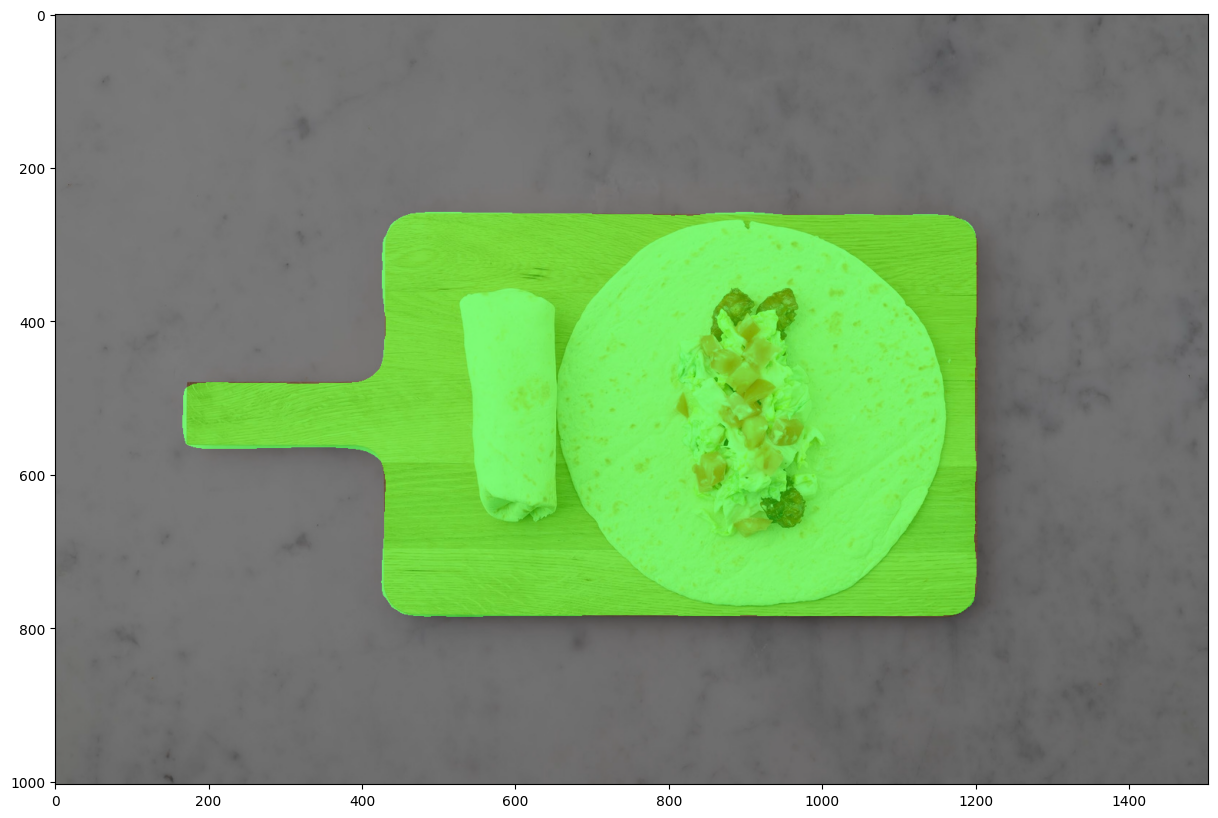

In [0]:
def visualize_segmentation(image_path: str, predicted_segmentation_map: np.ndarray):
    """
    Displays the segmentation map overlaid on the original image.

    Args:
        - image_path: Path to the original image.
        - predicted_segmentation_map: Predicted binary segmentation map.
    """
    def ade_palette() -> list[list[int]]:
        """Returns RGB color values for each class."""
        return [
            [0, 0, 0], # Background (black)
            [0, 255, 0] # Dish (green)
        ]

    # Create an empty image with the same shape as the segmentation map
    color_seg = np.zeros((predicted_segmentation_map.shape[0],
                        predicted_segmentation_map.shape[1], 3), dtype=np.uint8)

    # Map each label to its corresponding color
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[predicted_segmentation_map == label, :] = color

    # Convert the color image from RGB to BGR for OpenCV compatibility
    color_seg = color_seg[..., ::-1]

    # Open the image file
    image = Image.open(image_path)

    # Overlay the segmentation mask on the original image
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    # Display the result
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

# Post-process the model outputs to generate a segmentation map
predicted_segmentation_map = feature_extractor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

visualize_segmentation(IMAGE_PATH, predicted_segmentation_map)

#### Remove background

Final result as returned by the API.

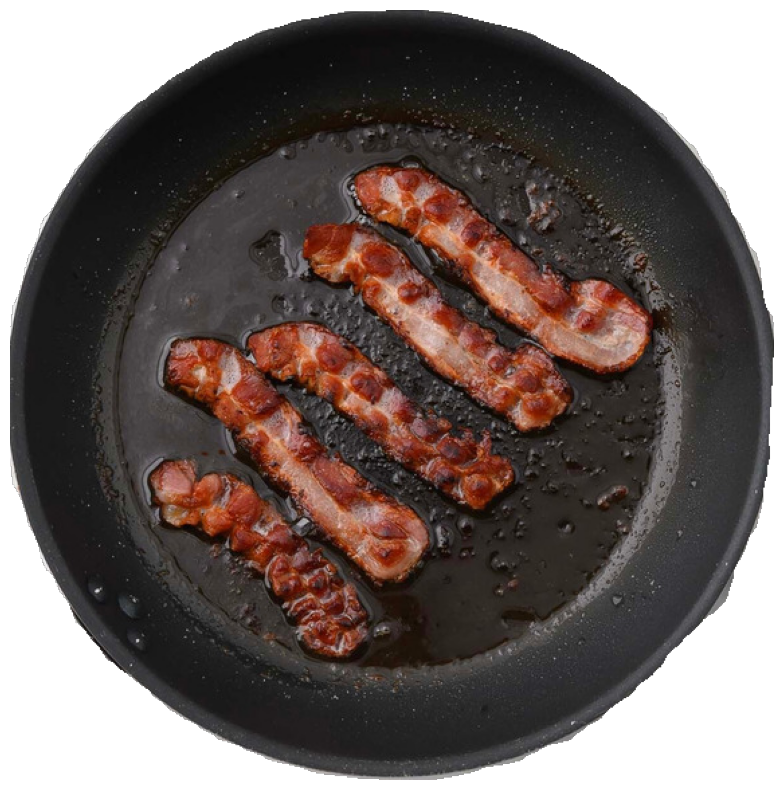

In [0]:
def crop_image_with_transparent_background(image_path: str, predicted_segmentation_map: np.ndarray):
    """
    Displays the cropped image with transparent background based on the predicted segmentation mask.

    Args:
        - image_path: Path to the original image.
        - predicted_segmentation_map: The predicted binary segmentation map.
    """
    # Load original image
    image = Image.open(image_path).convert("RGBA")

    # Convert segmentation map to binary mask (1 for foreground, 0 for background)
    binary_mask = (predicted_segmentation_map == 1).astype(np.uint8)

    # Create RGBA image for the mask
    mask = Image.new("L", (binary_mask.shape[1], binary_mask.shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    for y in range(binary_mask.shape[0]):
        for x in range(binary_mask.shape[1]):
            if binary_mask[y, x] == 1:
                draw.point((x, y), fill=255)

    # Apply mask to the original image to make the background transparent
    image_with_transparency = Image.composite(image, Image.new("RGBA", image.size), mask)

    # Find bounding box of foreground
    foreground_indices = np.where(binary_mask == 1)
    if len(foreground_indices[0]) == 0 or len(foreground_indices[1]) == 0:
        print("No foreground detected in the segmentation map.")
        return

    top_left_y = np.min(foreground_indices[0])
    bottom_right_y = np.max(foreground_indices[0])
    top_left_x = np.min(foreground_indices[1])
    bottom_right_x = np.max(foreground_indices[1])

    # Crop image with transparency using bounding box
    cropped_image_with_transparency = image_with_transparency.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

    # Display cropped image with transparency
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image_with_transparency)
    plt.axis("off")
    plt.show()

# Display the cropped image based on the segmentation mask
crop_image_with_transparent_background(IMAGE_PATH, predicted_segmentation_map)

#### Model Wrapper

Wrapping the fine-tuned model to handle model inference, cropping the image, and uploading the result to an S3 bucket.

- Create `RecipeCropper` wrapper ready for deployment.

In [0]:
class RecipeCropper(mlflow.pyfunc.PythonModel):
    """
    Custom model for image segmentation using a pre-trained SegFormer model.
    
    Segments input images using a pre-trained SegFormer model, crops the segmented region
    with transparent background, and uploads the result to an S3 bucket.

    Args:
        - model_path: Path to the pre-trained SegFormer model.
    """
    def __init__(self, model_path: str):
        self.model = SegformerForSemanticSegmentation.from_pretrained(model_path)
        self.feature_extractor = SegformerFeatureExtractor.from_pretrained(model_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.model.eval()

    def load_context(self, context):
        """
        Loads context method to initialize non-pickeable components: S3 client and logger.

        Args:
            - context: MLflow model context. Unused, but required by MLflow.
        """
        aws_default_region = os.getenv("AWS_DEFAULT_REGION")

        # Create S3 client
        self.s3 = boto3.client(
            "s3",
            region_name=aws_default_region
        )

        # Setup logging
        self._logger = self._setup_logger()
        self._logger.info("Logger initialized successfully.")

    def _setup_logger(self) -> logging.Logger:
        """Configure logging to stdout."""
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.INFO)
        handler = logging.StreamHandler(sys.stdout)
        handler.setLevel(logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        return logger

    def _read_file_from_dbfs(self, dbfs_path) -> BytesIO:
        """
        Read file from Databricks File System (DBFS).

        Args:
            - dbfs_path: Path to the file in DBFS.

        Returns:
            The file content as a BytesIO object.
        """
        token = os.getenv("DATABRICKS_TOKEN")
        host = os.getenv("DATABRICKS_HOST")
        url = f"{host}/api/2.0/dbfs/read"
        headers = {"Authorization": f"Bearer {token}"}
        json_data = {"path": dbfs_path}
        response = requests.get(url, headers=headers, json=json_data)
        if response.status_code != 200:
            raise Exception(f"Failed to read file from DBFS: {response.text}")
        data = response.json()
        return BytesIO(base64.b64decode(data['data']))
    
    def _crop_image(self, image: Image.Image, predicted_segmentation_map: np.ndarray) -> str:
        """
        Crops an image based on the segmentation map and saves it locally with a transparent background.

        Args:
            - image: Original image
            - predicted_segmentation_map: Segmentation map.

        Returns:
            Local path to the cropped image.
        """
        # Create binary mask where the segmentation map == 1
        binary_mask = (predicted_segmentation_map == 1).astype(np.uint8)

        # Create a mask image and draw the binary mask over it
        mask = Image.new("L", (binary_mask.shape[1], binary_mask.shape[0]), 0)
        draw = ImageDraw.Draw(mask)
        for y in range(binary_mask.shape[0]):
            for x in range(binary_mask.shape[1]):
                if binary_mask[y, x] == 1:
                    draw.point((x, y), fill=255)

        # Apply mask to original image to create image with transparency
        image_with_transparency = Image.composite(image, Image.new("RGBA", image.size), mask)

        # Find bounding box of segmented region
        foreground_indices = np.where(binary_mask == 1)
        if len(foreground_indices[0]) == 0 or len(foreground_indices[1]) == 0:
            print("No foreground detected in segmentation map.")
            return
        
        top_left_y = np.min(foreground_indices[0])
        bottom_right_y = np.max(foreground_indices[0])
        top_left_x = np.min(foreground_indices[1])
        bottom_right_x = np.max(foreground_indices[1])

        # Crop the image to the bounding box
        cropped_image_with_transparency = image_with_transparency.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

        # Save the cropped image locally
        local_path = "/tmp/result.png"
        cropped_image_with_transparency.save(local_path, "PNG")

        self._logger.info(f"Cropped image saved locally at: {local_path}")

        return local_path
    
    def predict(self, context, model_input) -> str:
        """
        Predicts the segmentation map of an image, crops the segmented region, and uploads the result to S3.

        Args:
            - context: The context of the MLflow model. Unused, but required by MLflow.
            - model_input: Dictionary containing the input parameters within the 'inputs' key.
                - image_path: Path to the input image.

        Returns:
            S3 URL of the uploaded cropped image.

        Example:
            model_input = {
                "image_path": "https://example.com/image.jpg",
            }
            s3_url = model.predict(context, model_input)
        """
        self._logger.info(f"Received model_input: {model_input}")

        # Get image path and bucket name
        image_path = model_input.get("image_path")
        bucket_name = os.getenv("BUCKET_NAME")

        if isinstance(image_path, np.ndarray):
            image_path = image_path.item()

        # Create s3_key from original image name
        original_image_name = os.path.basename(image_path)
        result_image_name = os.path.splitext(original_image_name)[0] + "_cropped.png"
        s3_key = "recipecropper/results/" + result_image_name

        self._logger.info(f"image_path: {image_path}")
        self._logger.info(f"bucket_name: {bucket_name}")
        self._logger.info(f"s3_key: {s3_key}")

        # Download image from URL or DBFS
        try:
            if image_path.startswith('http') or image_path.startswith('https'):
                self._logger.info("Downloading from URL...")
                response = requests.get(image_path)
                if response.status_code != 200:
                    raise Exception(f"Failed to download image from URL: {response.text}")
                image_data = BytesIO(response.content)
            else:
                self._logger.info("Reading from DBFS...")
                image_data = self._read_file_from_dbfs(image_path)
            image = Image.open(image_data).convert("RGB") # 21
        except Exception as e:
            self._logger.error(f"Error reading image: {e}")
            raise e

        self._logger.info("Image read successfully.")
        
        # Preprocess image using feature extractor
        inputs = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(self.device)

        # Perform inference with model
        with torch.no_grad():
            outputs = self.model(pixel_values=pixel_values)
            logits = outputs.logits.cpu()

        # Post-process segmentation_map
        predicted_segmentation_map = self.feature_extractor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
        predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

        self._logger.info(f"Segmentation inference completed successfully.")

        # Crop the image
        local_path = self._crop_image(image, predicted_segmentation_map)

        # Upload to S3
        self.s3.upload_file(local_path, bucket_name, s3_key)
        s3_url = f"https://{bucket_name}.s3.{os.environ['AWS_DEFAULT_REGION']}.amazonaws.com/{s3_key}"
        self._logger.info(f"Successfully uploaded cropped image to S3 at: {s3_url}")

        # Delete local file after upload
        os.remove(local_path)
        self._logger.info(f"Local cropped image file deleted after upload.")

        return s3_url

In [0]:
# Testing wrapper before deployment

root_dir = Path("<PATH>") # Check if model_path: str | Path
MODEL_PATH = "<PATH>/PoC/best_model_ex09"

custom_model = RecipeCropper(model_path=MODEL_PATH)
context = None
custom_model.load_context(context)

image_path = 'https://res.cloudinary.com/image/R13_W13_DE_L19841-3_Main_low-ef495675.jpg'
model_input = {
    'image_path': image_path
}

s3_url = custom_model.predict(context, model_input)
print(f"Result uploaded to: {s3_url}")

### Deployment

#### Deployment with Databricks
- Register model using MLflow
- Deploy using user interface
- Test endpoint

#### Register model

In [0]:
MODEL_PATH = "<PATH>/PoC/model_ex09"

custom_model = RecipeCropper(model_path=MODEL_PATH)

# Log the model
with mlflow.start_run() as run:
    mlflow.pyfunc.log_model(
        artifact_path="model",
        python_model=custom_model,
        conda_env={
            'name': 'mlflow-env',
            'channels': ['conda-forge'],
            'dependencies': [
                'python=3.10.12',
                'pip',
                {
                    'pip': [
                        'mlflow==2.14.2',
                        'torch==2.3.1',
                        'torchvision==0.18.1',
                        'transformers==4.42.3',
                        'evaluate==0.4.2',
                        'accelerate==0.32.1',
                        'boto3',
                        'pillow'
                    ]
                }
            ]
        }
    )

# Register the model
mlflow.register_model(
    model_uri=f"runs:/{run.info.run_id}/model",
    name="oma-recipecropper-v1"
)

#### Test endpoint

In [0]:
url = "https://company.cloud.databricks.com/serving-endpoints/oma-recipecropper-v1/invocations"
headers = {
    "Authorization": f"Bearer {os.environ.get('DATABRICKS_TOKEN')}",
    "Content-Type": "application/json"
}
data = {
    "inputs": {
        "image_path": "https://img.company.com/step-c1432550.jpg"
    }
}

response = requests.post(url, headers=headers, json=data)
print(response.json())

{'predictions': 'https://<AWS_BUCKET_NAME>.s3.<AWS_DEFAULT_REGION>.amazonaws.com/recipecropper/results/step-c1432550_cropped.png'}


### Databricks DBFS Utils

Utility blocks to perform operations in DBFS.

- List folder contents
- Copy files between folders
- Get folder size
- Remove folder recursively
- Compress folder contents
- Upload file to S3 bucket
- Extract zip file

In [0]:
# List folder contents
%fs ls <PATH>/PoC

In [0]:
# Copy files between folders
source_folder = "<PATH>/PoC/step_dataset_processed_02"
destination_folder = "<PATH>/PoC/step_dataset_processed_01"

dbutils.fs.cp(source_folder, destination_folder, recurse=True)

In [0]:
# Get folder size
def get_directory_size(path):
    """
    Calculate the size of a directory in bytes.
    
    Args:
        path (str): The path of the directory.
    
    Returns:
        int: The total size of the directory in bytes.
    """
    total_size = 0
    try:
        files = dbutils.fs.ls(path)
        for file in files:
            if file.isDir():
                # Recursively calculate the size of subdirectories
                total_size += get_directory_size(file.path)
            else:
                total_size += file.size
    except Exception as e:
        print(f"An error occurred: {e}")
    
    return total_size

# Calculate directory size
directory_path = "<PATH>/PoC/step_dataset_01"
directory_size = get_directory_size(directory_path)
print(f"Size of '{directory_path}': {directory_size / (1024 ** 3):.2f} GB")

In [0]:
# Remove folder recursively
folder_path = "<PATH>/step_dataset_01/processed"

dbutils.fs.rm(folder_path, recurse=True)

In [0]:
# Compress folder contents
dir_path = "<PATH>/finetuned-segformer-step_dataset_simple"
tar_gz_file = "<PATH>/finetuned-segformer-step_dataset_simple.tar.gz"

# Run the tar command to compress the directory
import os
os.system(f"tar -czvf {tar_gz_file} -C {dir_path} .")

In [0]:
# Upload file to S3 bucket
import os
import boto3

os.environ['AWS_ACCESS_KEY_ID'] = "****"
os.environ['AWS_SECRET_ACCESS_KEY'] = "****"
os.environ['AWS_DEFAULT_REGION'] = "<AWS_DEFAULT_REGION>"

# Create S3 client
s3 = boto3.client("s3")

# Define DBFS path and local path
dbfs_path = "dbfs:<PATH>/finetuned-segformer-step_dataset_simple.tar.gz"
local_path = "/tmp/finetuned-segformer-step_dataset_simple.tar.gz"

# Copy file from DBFS to local filesystem
dbutils.fs.cp(dbfs_path, "file:" + local_path)

# Define S3 bucket name and S3 key (path) where the file will be stored
bucket_name = "<AWS_BUCKET_NAME>"
s3_key = "finetuned-segformer-step_dataset_simple.tar.gz"

# Upload file to S3
s3.upload_file(local_path, bucket_name, s3_key)

print(f"File uploaded to S3 bucket: '{bucket_name}' with key: '{s3_key}'")

In [0]:
# Extract dataset.zip
import zipfile

dataset_name = "step_dataset_processed_02"

z_path = f'<PATH>/PoC/{dataset_name}.zip'
z_extract_to = f'<PATH>/PoC/'

with zipfile.ZipFile(z_path, 'r') as z_ref:
    z_ref.extractall(z_extract_to)